# Øving 4, TMA4320

* **Veiledning:** Torsdag 10.15-12.00 og fredag 08.15-10.00 i R73 og på Zoom. 
* **Innleveringsfrist:** Mandag 28.02, kl. 23.59.
* **Innleveringsmetode** Følgende to krav er nødvendig for godkjenning
    1. Opplasting av Jupyter Notebook (individuelt) i Blackboard
    2. Svare på skjema med kontrollspørsmål i Blackboard (alle spørsmålene må være riktig besvart for godkjenning)
    
Før du starter, gå gjennom notatet: 

* [Numerical solution of ordinary differential equations](http://www.math.ntnu.no/emner/TMA4320/2022v/notebooks/ODE.ipynb) 

In [3]:
%matplotlib inline

import numpy as np
from math import factorial
import matplotlib.pyplot as plt
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)

I denne oppgaven skal du skrive en adaptiv løser for ordinære differensialligninger, basert på Bogacki-Shampine-paret
$$
\begin{array}{c|cccccl}
    0 & 0 \\ 
    1/2 & 1/2  \\ 
    3/4 & 0 & 3/4 \\ 
    1 & 2/9 & 1/3 & 4/9 \\ \hline
       & 2/9 & 1/3 & 4/9 & 0  & & \quad & Metode 1 \\ \hline
       & 7/24 & 1/4 & 1/3 & 1/8 & &  & Metode 2 
   \end{array}
$$




**Oppgave 1**
Bruk ordensbetingelsene i notatet til å bestemme ordenen til de to metodene. 

**Kontrollspørsmål 1** Hva er ordenen til metode 1.

**Kontrollspørsmål 2** Hva er ordenen til metode 2. 

**Kontrollspørsmål 3-4** Diverse spørsmål om feilestimering.

Det er løsningen fra Metode 1 som brukes for å beregne $\mathbf{y}_{n+1}$, Metode 2 er for feilestimering. 

Bogacki-Shampines metode kan implementeres effektivt, ved å utnytte det faktum at $k_4$ i et steg er det samme som $k_1$ i det neste (hvorfor). 
Denne egenskapen kalles ofte FSAL (first same as last). 

**Oppgave 2**
Skriv en adaptiv ODE-løser basert på Bogacki-Shampines metode.
For å få full utntyttelse av FSAL-egenskapen anbefales det at du skriver koden selv fra begynnelsen av, ikke bare kopiere fra notatet. 

Test løseren din på problemet

$$
u'=v,\ v'=-4u,\quad u(0)=1,\ v(0)=0,\ [x_0,x_{end}]=[0,2\pi]
$$

som har eksakt løsning $u(x)=\cos 2x$ og $v(x)=-2\sin 2x$. 



**Oppgave 3**
Anvend rutinen på Brusselator-problemet nedenfor. Sett pessimistfaktor $P=0.9$, bruk
$x_0=0$, $x_{end}=20$, og $tol=10^{-5}$. La $h_0=0.1$.

\begin{align*}
u' &= 1 + u^2 v - 4 u, & u(0)&=1 \\
v' &= 3u - u^2 v,  & v(0)&=2.9
\end{align*}

Lag et plott som viser hver av løsningskomponentene som funksjon av $t$ (i samme plott)
Suppler med et plott rett under dette som viser hvordan skrittlengden varierer med $t$.
Her kan det være nyttig å bruke numpy-funksjonen *diff*.

**Kontrollspørsmål 5-7** Du blir her bedt om å rapportere statistikk fra eksperimentet i Oppgave 3.
Antall skritt koden din bruker, antall funksjonsevalueringer (feval) og antall forkastede skritt.
*NB!* Bruk FSAL-egenskapen, ellers får du gale svar. 

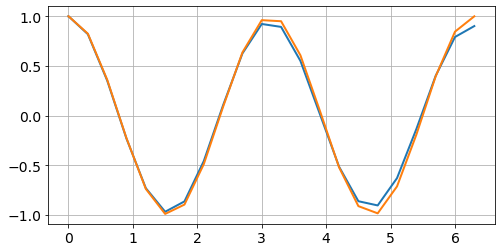

Num of steps:  287
Num of function call:  1584
Num of rejected steps  0


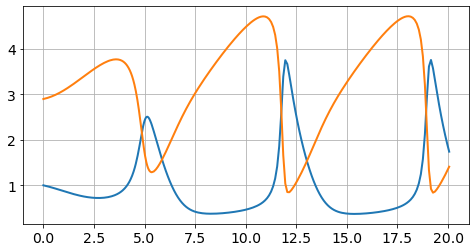

In [17]:
'''Variabel skrittlengde impementasjon bygd på innbygd par av orden (3,2) - Bogacki og Shampine'''

def step_bogshamp(f, x, y, h):
    k_1 = f(x, y)
    k_2 = f(x + h/2, y + h*k_1/2)
    k_3 = f(x + 3*h/2, y + 3*h*k_2/4)
    y_1 = y + h*(2/9*k_1 + 1/3*k_2 + 4/9*k_3)
    k_4 = f(x + h, y_1)
    z_1 = y + h*(7/24*k_1 + 1/4*k_2 + 1/3*k_3 + 1/8*k_4)
    
    error = h*((2/9-7/24)*k_1+ (1/3-1/4)*k_2+(4/9-1/3)*k_3 + (0-1/8)*k_4)
    
    return x+h, y_1, z_1, h, error

def bogshamp(t0, tend, y0, f, h0, tol, maksit):
    x_array = np.array([t0])
    y_array = np.array(y0)
    its = 0
    
    while (x_array[-1] < tend):
        y_temp = y_array[len(y_array)-len(y0)::]
        error = 0
        
        x, y, z, h, error = step_bogshamp(f, x_array[-1], y_temp, h0)
        error = np.max(np.abs(error))

        its += 4
        s_rej = 0
        count = 0      
        while (error > tol and its < maksit):  
                   
            x, y, z, h, error = step_bogshamp(f, x_array[-1], y_temp, (tol/error)**(1/(0.9+1))*h)
            error = np.max(np.abs(error))
            s_rej +=1
            its += 4                   
            count += 1
                         
        x_array = np.append(x_array, [x])
        y_array = np.append(y_array, y)
        
    return x_array, y_array, len(y0), its, s_rej

def f(x, y):
    return np.array([y[1], -4*y[0]])

x = [0]
y = [1,0]

t, y, dim, fc, sj  = bogshamp(0, 2*np.pi, y, f, 0.3, 10e-8, 5)

plt.plot(t,y[::dim])
plt.plot(t,np.cos(2*t))

plt.show()





t0 = 0
tend = 20
tol = 1e-5
h0 = 0.1

def f(x,y):
    return np.array([1+y[0]**2*y[1]-4*y[0], 3*y[0]-y[0]**2*y[1]])

x = [t0]
y0 = [1, 2.9]

x, y, dim, fc, rj = bogshamp(x, tend, y0, f, h0, tol, 1000)

plt.plot(x, y[::dim])
plt.plot(x, y[1::dim])

print("Num of steps: ", len(x)-1)
print("Num of function call: ", fc)
print("Num of rejected steps ", rj)

In [33]:
def ode_solver(f, x0, xend, y0, h0, tol = 1.e-6, method=step_bogshamp2):
    '''
    Generic solver for ODEs
        y' = f(x,y), y(a)=y0
    Input: f, the integration interval x0 and xend, 
           the stepsize h and the method of choice.  
       
    Output: Arrays with the x- and the corresponding y-values. 
    '''
    #Initializing:
    x_num = np.array([x0])
    y_num = np.array([y0])        

    xn = x0                # Running values for  x, y and the stepsize h
    yn = y0 
    max_it = 100000        # Maximum allowed calls of method
    ncall = 0
    h = h0

    # Main loop
    while xn < (xend - 1.e-10):
        # Adjusting stepsize for last step
        if xn + h > xend:                   
            h = xend - xn 
        
        # Doing one step
        x_try, y_try, error_est, p = method(f, xn, yn, h)
        error_est = np.linalg.norm(error_est, np.inf)
        ncall +=1
        
        if error_est <= tol:   
            # Solution accepted
            xn = x_try    
            yn = y_try
            
            y_num = np.concatenate((y_num, np.array([yn])))
            x_num = np.append(x_num, xn)
            
        
        # Extend arrays x and y
        x_num = np.append(x_num,xn)
        y_num = np.concatenate((y_num, np.array([yn])))
        
        #Stesize adjusting 
        h = 0.8*(tol/error_est)**(1/(p+1))*h
        
        # Stop with a warning in the case of max calls to method
        if ncall > max_it:
            print('Maximum number of method calls')
            return x_num, y_num
        
    print(f'Steps = {ncall:4d}')
    print(f'Accepted steps = {len(x_num)-1:4d}')
    print(f'Rejected steps = {ncall-len(x_num)+1:4d}')
    print(f'Funccalls = {ncall*3:4d}')   
    
    return x_num, y_num

def step_bogshamp2(f, x, y, h):
    k_1 = f(x, y)
    k_2 = f(x + h/2, y + h*k_1/2)
    k_3 = f(x + 3*h/2, y + 3*h*k_2/4)
    y_1 = y + h*(2/9*k_1 + 1/3*k_2 + 4/9*k_3)
    k_4 = f(x + h, y_1)
    z_1 = y + h*(7/24*k_1 + 1/4*k_2 + 1/3*k_3 + 1/8*k_4)
    
    error = y_1-z_1
    p = 0.9
    
    return x+h, y_1, error, p

x, y = ode_solver(f, t0, tend, y0, h0, tol = 1.e-5, method=step_bogshamp2)

Steps =  449
Accepted steps =  865
Rejected steps = -416
Funccalls = 1347


In [ ]:
@jit(nopython=True, fastmath=True)
def NMF2(A, d, div_const, tol, max_it = 1000):
    """
    Input: 
        A: mxn matrix
        d: number of components
        div_const: safe division constant
        tol: tolerance
    Output:
        Returns W and H such that WH = A_nmf (approximate NMF factorization)
    """

    W_rows = A.shape[0]
    H_cols = A.shape[1]

    W_cols = d
    H_rows = d

    delta = 10e-7
    
    #Creating random matrix H0 and H0 and scaling them
    H0 = (np.random.uniform(0.0, 1.0, size=(H_rows,H_cols)) * np.sqrt(np.mean(A)/d)).astype(np.float32)
    W0 = (np.random.uniform(0.0, 1.0, size=(W_rows,W_cols)) * np.sqrt(np.mean(A)/d)).astype(np.float32)

    Hk = H0
    Wk = W0
    H = Hk
    norm_arr = np.zeros(max_it)

    for k in range(max_it):        
        H = (np.divide(np.multiply(Hk, np.dot(Wk.transpose(), A.astype(np.float32))) ,np.dot(np.dot(Wk.transpose(),Wk),Hk)+div_const)).astype(np.float32)
        W = (np.divide((np.multiply(Wk, np.dot(A.astype(np.float32), H.transpose()))), (np.dot(np.dot(Wk,H),H.transpose()) + div_const))).astype(np.float32)
        Hk = H
        Wk = W
        
        norm_arr[k] = np.linalg.norm(A - np.dot(W, H), 'fro')
    
    A_nmf = np.dot(W,H)

    return W, H, A_nmf, norm_arr


div_const = 10**(-9)
d = 1 
tol = 0.1

#NMF2(A1, d, div_const, tol)